In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import networkx as nx
import pywt
from scipy.fftpack import fft, rfft
from pymssa import MSSA


matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

/root/miniconda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Data loading

In [3]:
chaos = pd.read_csv('./chaos_sample_5.txt', delimiter='\t')
timestamps = np.array(chaos.index)

In [4]:
chaos.head()

,5001,5002,5003,5004,5005,5006,5007,5008,5009,5010,...,5356,5357,5358,5359,5360,5361,5362,5363,5364,5365
90000.0,-0.000018,-0.001784,-0.917791,4.408553,-0.421157,-0.001683,-0.001692,-35.029201,-0.898255,2.201222,...,-0.000024,-0.000349,-0.000304,-0.000090,-0.000115,-0.000312,-0.000345,-0.000689,-0.000311,-0.000064
90018.0,0.000027,-1.190258,-0.914819,5.881844,-2.097727,-4.178118,-5.418659,-48.139564,-4.477319,1.323359,...,0.000036,0.000515,0.000449,0.000133,0.000170,0.000461,0.000509,0.001016,0.000459,0.000095
90036.0,-0.000092,1.184401,0.910830,7.343917,-0.005728,-1.401305,-2.040379,-52.529410,-1.801491,2.196292,...,-0.000123,-0.001773,-0.001544,-0.000458,-0.000586,-0.001587,-0.001750,-0.003498,-0.001578,-0.000327
90054.0,-0.000174,1.176377,4.573808,7.338222,-0.011130,3.472234,2.699381,-26.249873,-3.602408,5.275150,...,-0.000232,-0.003344,-0.002912,-0.000864,-0.001105,-0.002992,-0.003300,-0.006596,-0.002976,-0.000617
90074.0,-0.000287,1.165260,7.318367,8.800920,2.081696,6.251727,3.367077,-26.268146,-0.029089,8.352831,...,-0.000383,-0.005520,-0.004807,-0.001426,-0.001825,-0.004939,-0.005448,-0.010888,-0.004913,-0.001019


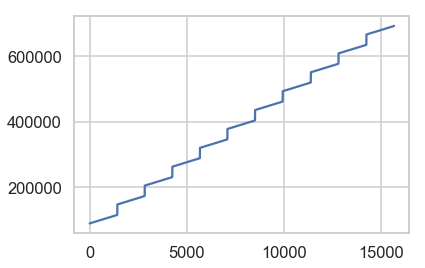

In [5]:
plt.plot(timestamps)

## Preprocessing

  1. Divide samples according to 
  2. Resample it with 18 sec intervals
  3. Smoothing with `savgol_filter`(not interested in high frequencies __for now__)

In [6]:
from scipy.signal import savgol_filter
from scipy import interpolate

In [7]:
X_divided = []
timestamps_divided = []

t_prev = 0
argdiff = np.argwhere(np.diff(timestamps) > 100).ravel()
for t_next in argdiff[:-1][np.diff(argdiff) > 100]:
    if t_next - t_prev < 20:
        t_prev = t_next
        continue
    print(t_next - t_prev)
    X_selected = chaos.values[t_prev + 1:t_next, :]
    timestamps_selected = timestamps[t_prev + 1: t_next]
    f = interpolate.interp1d(timestamps_selected, X_selected, axis=0)
    ts_resampled = np.arange(timestamps_selected.min(), timestamps_selected.max(), 18.)
    X_resampled = f(ts_resampled)
    timestamps_divided.append(ts_resampled)
    X_divided.append(savgol_filter(X_resampled, window_length=21, polyorder=3, axis=0))
    t_prev = t_next

/root/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


1421
1410
1421
1422
1415
1422
1425
1447
1425
1435


In [8]:
d = 0
X = X_divided[d]
timestamps = timestamps_divided[d]

## Rolling window статистики

In [9]:
import dcor

In [ ]:
dcor.distance_correlation()

In [12]:
i, j = 2, 4


array([ 0.24541394,  2.04028103,  3.41629011, ..., -4.26857013,
       -4.26568679, -4.26333695])

In [13]:
dcor.distance_correlation(X[:, i], X[:, j])

0.2061594730979886

In [14]:
dcor.distance_covariance(X[:, i], X[:, j])

2.1456065393062516

In [15]:
dcor.distance_stats(X[:, i], X[:, j])

Stats(covariance_xy=2.1456065393062516, correlation_xy=0.2061594730979886, variance_x=9.300311458667563, variance_y=11.646517516703105)

In [8]:
import pywt
from scipy.fftpack import fft, rfft
# Cross-Spectral Density 
# https://nbviewer.jupyter.org/github/mattijn/pynotebook/blob/master/ipynotebooks/Python2.7/2016/2016-05-25%20cross-spectral%20analysis.ipynb
# https://www.researchgate.net/publication/262260657_Characterization_of_Millennial-Scale_Climate_Variability
# https://hal.archives-ouvertes.fr/hal-01589464/document
# http://www.alivelearn.net/?p=1169
# http://paos.colorado.edu/research/wavelets/bams_79_01_0061.pdf
# http://www.milanor.net/blog/wp-content/uploads/2014/07/SingularSpectrumAnalysisWithRssa.pdf

In [53]:
def construct_hierarchical_distances(x, y, distance_metric, i=None, j=None, distance_matrix=None, min_length=10):
    assert len(x) == len(y)
    if len(x) < min_length:
        return
    if distance_matrix is None:
        distance_matrix = dict()
        i = 0
        j = len(x)
    distance_matrix[(i, j)] = distance_metric(x, y)
    n = len(x) // 2
    construct_hierarchical_distance(x[:n], y[:n], distance_metric=distance_metric, 
                                    i=i, j=j - n, distance_matrix=distance_matrix, min_length=min_length)
    construct_hierarchical_distance(x[:n], y[:n], distance_metric=distance_metric, 
                                    i=i + n, j=j, distance_matrix=distance_matrix, min_length=min_length)
    return distance_matrix


def construct_rolling_distances(x, y, distance_metric, window=10, step=5):
    assert len(x) == len(y)
    if len(x) < window:
        return None
    distance_matrix = []
    offset = 0
    while offset < len(x):
        distance_matrix.append(distance_metric(x[offset: offset + window], 
                                               y[offset: offset + window]))
        offset += step
    return np.array(distance_matrix)

In [54]:
import warnings
warnings.filterwarnings("ignore")

In [55]:
from scipy.stats import pearsonr
from scipy.signal import welch, coherence
from scipy.spatial.distance import cosine
from scipy.stats import energy_distance

def power_spectrum_distance(x, y):
    return coherence(x, y, nperseg=len(x) // 6)[1].mean()
    return 1 - cosine(np.log(welch(x, nperseg=len(x) // 6)[1]), np.log(welch(y, nperseg=len(x) // 6)[1]))


def wavelet_spectrum_distance(x, y, wavelet='db2'):
    (cAx, cDx) = pywt.dwt(x, wavelet)
    (cAy, cDy) = pywt.dwt(y, wavelet)
    return 1 - cosine(cAx, cAy)

def std_norm(x, axis=-1):
    return (x - x.mean(axis=axis, keepdims=True)) / x.std(axis=axis, keepdims=True)

In [56]:
window = 100
step = 25

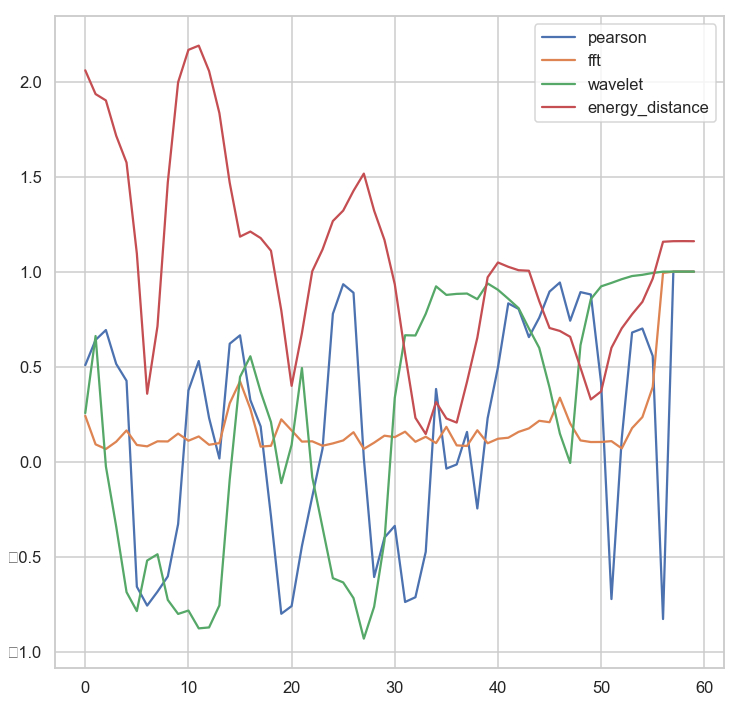

In [57]:
i, j = 2, 4

plt.figure(figsize=(12, 12))
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), lambda x, y: pearsonr(x, y)[0], window=window, step=step), 
         label='pearson')
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), power_spectrum_distance, window=window, step=step), label='fft')
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), wavelet_spectrum_distance, 
                                     window=window, step=step), label='wavelet')
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), energy_distance, 
                                     window=window, step=step), label='energy_distance')
plt.legend()
plt.show()

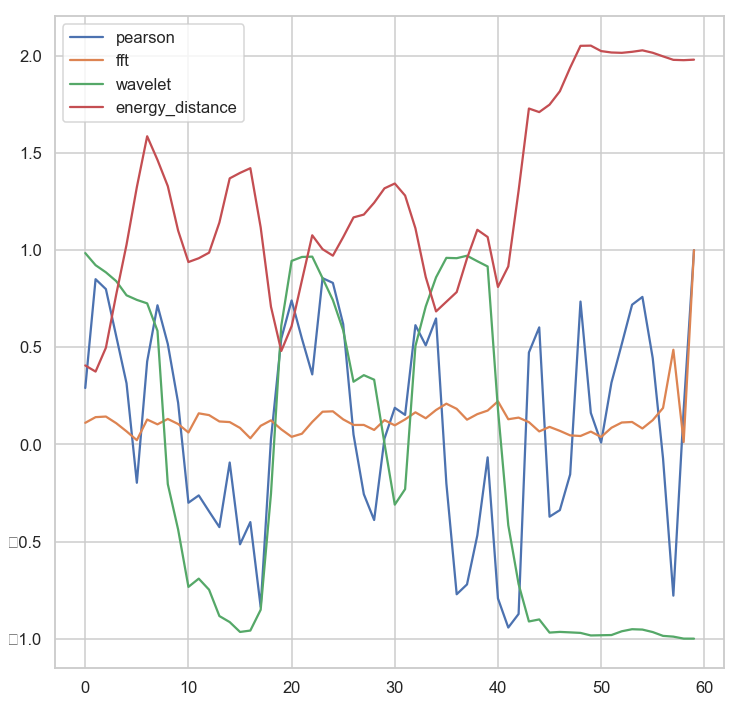

In [58]:
i, j = 0, 6

plt.figure(figsize=(12, 12))
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), lambda x, y: pearsonr(x, y)[0], window=window, step=step), 
         label='pearson')
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), power_spectrum_distance, window=window, step=step), label='fft')
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), wavelet_spectrum_distance, 
                                     window=window, step=step), label='wavelet')
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), energy_distance, 
                                     window=window, step=step), label='energy_distance')
plt.legend()
plt.show()

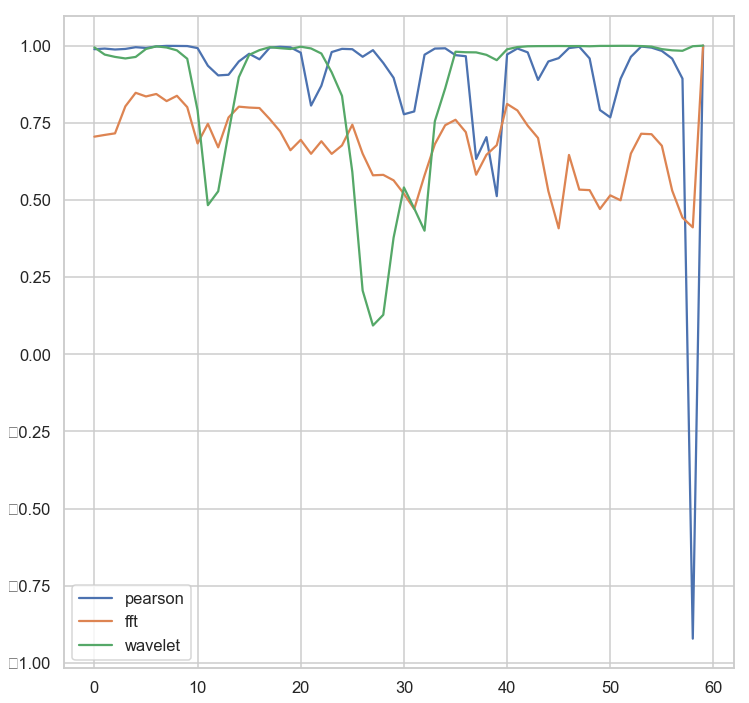

In [15]:
i, j = 5, 6

plt.figure(figsize=(12, 12))
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), lambda x, y: pearsonr(x, y)[0], window=window, step=step), 
         label='pearson')
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), power_spectrum_distance, window=window, step=step), label='fft')
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), wavelet_spectrum_distance, 
                                     window=window, step=step), label='wavelet')
plt.legend()
plt.show()

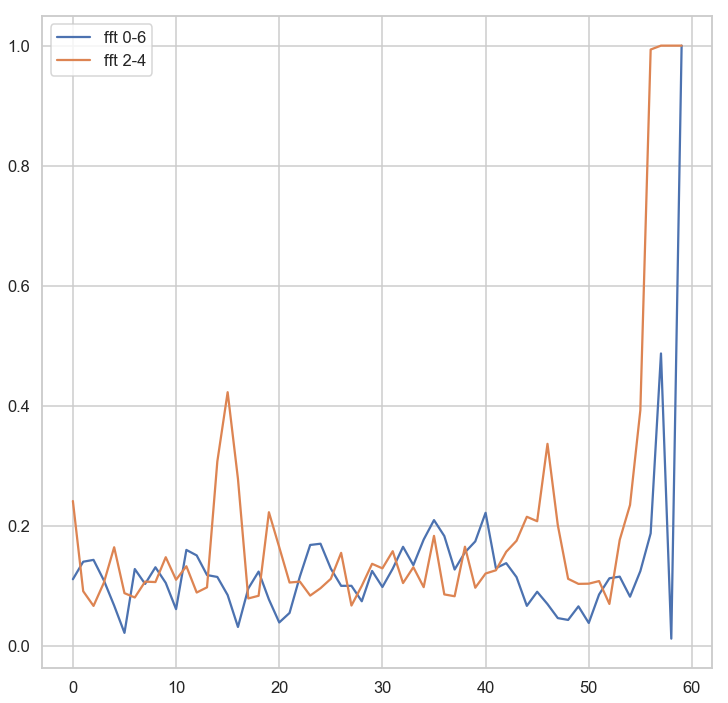

In [16]:
i, j = 0, 6

plt.figure(figsize=(12, 12))
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), power_spectrum_distance, window=window, step=step), label='fft {}-{}'.format(i, j))

i, j = 2, 4
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), power_spectrum_distance, window=window, step=step), label='fft {}-{}'.format(i, j))

plt.legend()
plt.show()

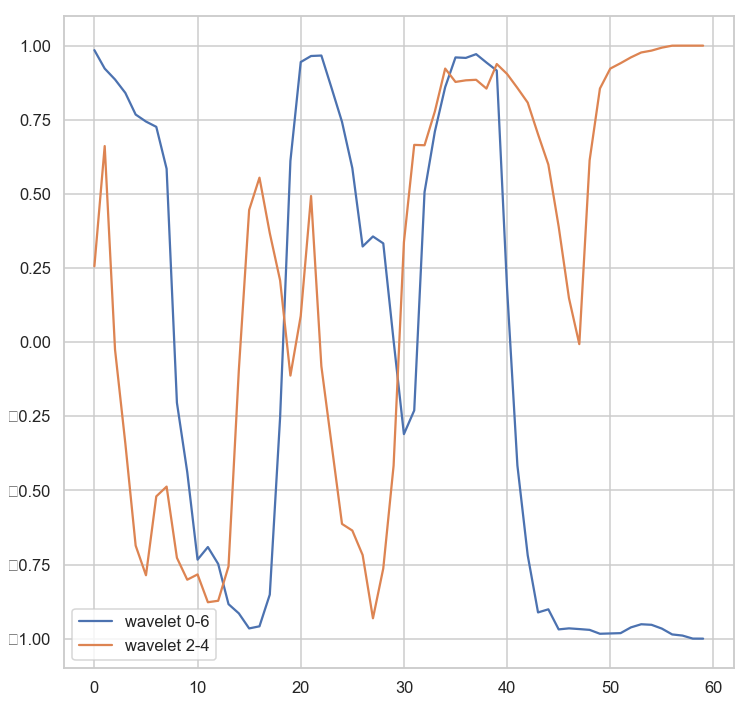

In [17]:
i, j = 0, 6

plt.figure(figsize=(12, 12))
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), wavelet_spectrum_distance, window=window, step=step), label='wavelet {}-{}'.format(i, j))


i, j = 2, 4
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), wavelet_spectrum_distance, window=window, step=step), label='wavelet {}-{}'.format(i, j))


plt.legend()
plt.show()

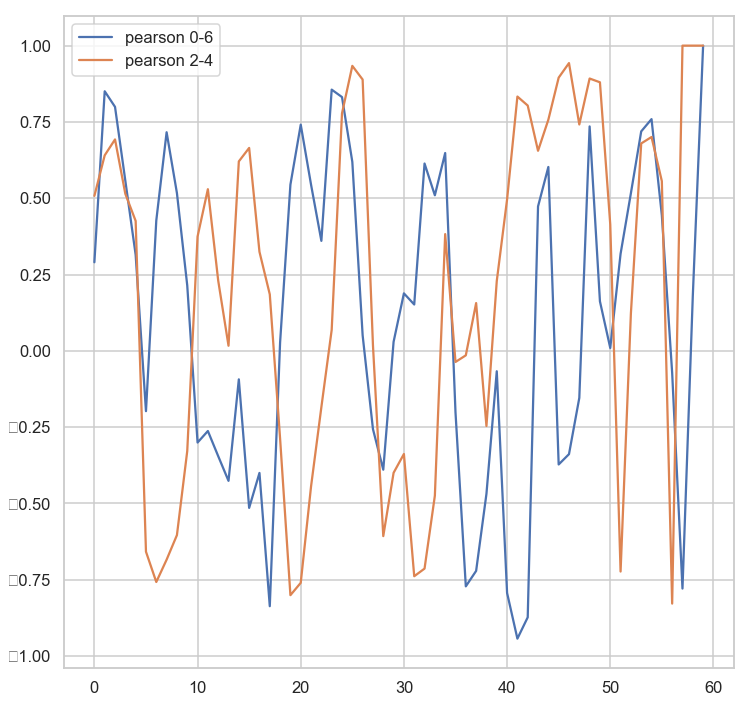

In [18]:
i, j = 0, 6

plt.figure(figsize=(12, 12))
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), lambda x, y: pearsonr(x, y)[0], window=window, step=step), label='pearson {}-{}'.format(i, j))

i, j = 2, 4
plt.plot(construct_rolling_distances(std_norm(X[:, i]), std_norm(X[:, j]), lambda x, y: pearsonr(x, y)[0], window=window, step=step), label='pearson {}-{}'.format(i, j))
plt.legend()
plt.show()